## We use this notebook to visualize the trained event-based-similarity (EBS) to see if the images have any similarities if their EBS is large, and to visualize some of the test process.

In [1]:
import os
import pickle 
import numpy as np
import torch
import re, json

import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from pretrain.data.visualcomet_preparetion.dataset_preparetion import RecordParseDataset, ImgPostivePairs

VCR_IMAGES_DIR = '/ibex/scratch/mag0a/Github/visual-comet/data/vcr1images'# os.environ['VCR_PARENT_DIR']
VCR_FEATURES_DIR = '/ibex/scratch/mag0a/Github/visual-comet/data/features'
record_cache = '/ibex/scratch/mag0a/Github/VL-BERT/pretrain/data/visualcomet_preparetion/cache/event_similarity_cleaned'

split='val'

In [2]:
import sys 
sys.path.append("/ibex/scratch/mag0a/Github/visual-comet") 
from utils.file_utils import read_and_parse_finetune_json

def load_records(vcg_dir='/ibex/scratch/mag0a/Github/visual-comet/data/visualcomet_annotations/'):
    records = {}
    splits = ['train', 'val']

    for s, split_ in enumerate(splits):
        split_filename = '{}_annots.json'.format(split)
        with open(os.path.join(vcg_dir, split_filename), 'rb') as f:
            records[split_] = json.load(f)

    return records

records = load_records()[split]


In [3]:
records[0]

{'img_fn': 'lsmdc_0010_Frau_Ohne_Gewissen/0010_Frau_Ohne_Gewissen_01.30.39.397-01.30.46.003@0.jpg',
 'movie': '0010_Frau_Ohne_Gewissen',
 'metadata_fn': 'lsmdc_0010_Frau_Ohne_Gewissen/0010_Frau_Ohne_Gewissen_01.30.39.397-01.30.46.003@0.json',
 'split': 'val',
 'place': 'inside',
 'event': '2 is carrying a note book and is walking toward a door',
 'intent': ['leave the room', 'transport the notebook'],
 'before': ['be looking for a certain office in the building',
  'ask the elevator operator for directions',
  'be a trained detective',
  'be at the scene of a crime'],
 'after': ['get into the elevator',
  'be taken to the correct floor',
  'exit the elevator thanking the elevator operator',
  'perform an investigation',
  'look for evidence']}

In [4]:
f = lambda str: re.sub("\d+", "[person]", str)

records_events = {}
for record in records:
    event = f(record['event'])
    if len(record['intent']) > 0:
        for intent in record['intent']:
            event += '; [intent] ' + f(intent)
    if 'place' in record:
        event += '; [place] ' + f(record['place'])
    img_fn = record['img_fn']
    if img_fn not in records_events:
        records_events[img_fn] = {event: [{'before': record['before'], 'after': record['after']}]}
    else:
        records_events[img_fn].update({event: [{'before': record['before'], 'after': record['after']}]})

In [5]:
record_img_event = []
parse_record_cache = os.path.join(record_cache, '{}_record_img_event.txt'.format(split))

with open(parse_record_cache, 'r+', encoding="utf-8") as f:
    for l in f.readlines():
        record_img_event.append(l.split(","))

record_img_event[0]

['lsmdc_0010_Frau_Ohne_Gewissen/0010_Frau_Ohne_Gewissen_01.30.39.397-01.30.46.003@0.jpg',
 'lsmdc_0010_Frau_Ohne_Gewissen/0010_Frau_Ohne_Gewissen_01.30.39.397-01.30.46.003@0.json',
 '[person] is carrying a note book and is walking toward a door; [intent] leave the room; [intent] transport the notebook; [place] inside\n']

In [6]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def visual_fig_with_box(record_img_event, idx, add_box=False, corlor=None):
    ref = record_img_event[idx]
    img_fn, event = ref[0], ref[2]
    
    print("idx: {}, event: {}".format(idx, event))
    jpg_path = os.path.join("/ibex/scratch/mag0a/Github/visual-comet/data/vcr1images", img_fn)
    I = mpimg.imread(jpg_path)
    
    
    figure = plt.figure(figsize=(30,30))
    ax = figure.add_subplot(2,2, 1)
    
    ax.imshow(I)
    
    if add_box:
        metadata_fn = ref['metadata_fn']
        with open(os.path.join(VCR_IMAGES_DIR, metadata_fn), 'r') as f:
            metadata = json.load(f)
        l = np.array(metadata['boxes'])

        l[:,2]=l[:,2]-l[:,0]
        l[:,3]=l[:,3]-l[:,1]
        for j in range(len(l)):
            ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],linewidth=2,edgecolor='w',facecolor='none'))
    

def transform(img):
    img = img.resize((300, 170), Image.ANTIALIAS)
    
    return img
    

def load_img(record_img_event, records_events, idx, verbose=False):
    ref = record_img_event[idx]
    img_fn, event = ref[0], ref[2]
    
    jpg_path = os.path.join("/ibex/scratch/mag0a/Github/visual-comet/data/vcr1images", img_fn)
    img = Image.open(jpg_path)
    img = transform(img)
    if verbose:
        print("idx: {}, event: {}, {}".format(idx, event, records_events[img_fn][event.replace('\n', '')]))
        print()
    return img


def clear_ax(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

def visual_multiple_fig(record_img_event, records_events, idx, positive_idxs, cosine_positive_dixs=[], verbose=False):
    figure = plt.figure(figsize=(17,3))
    
    if len(cosine_positive_dixs)==0:
        length = len(positive_idxs)+2
        width_ratios = [1]*(length)
        width_ratios[1] = 0.1
    else:
        length = len(positive_idxs)+2 + len(positive_idxs)+1
        width_ratios = [1]*(length)
        width_ratios[1] = 0.1
        width_ratios[len(positive_idxs)+2] = 0.1
    gridspec = dict(hspace=0.0, width_ratios=width_ratios)
    
    axs = figure.subplots(nrows=1, ncols=length, gridspec_kw=gridspec)
    
    I = load_img(record_img_event, records_events, idx, verbose)
    axs[0].imshow(I)    
    clear_ax(axs[0])
    
    axs[1].set_xlim([-1,1])
    axs[1].set_ylim([-1,1])
    axs[1].vlines(0, -0.7, 0.7, colors = "k", linestyles = "dashed")
    clear_ax(axs[1])


    for i, p_idx in enumerate(positive_idxs):
        I = load_img(record_img_event, records_events, p_idx, verbose)
        axs[2+i].imshow(I)
        clear_ax(axs[2+i])
    
    if len(cosine_positive_dixs)>0:
        axs[len(positive_idxs)+2].set_xlim([-1,1])
        axs[len(positive_idxs)+2].set_ylim([-1,1])
        axs[len(positive_idxs)+2].vlines(0, -0.7, 0.7, colors = "k", linestyles = "dashed")
        clear_ax(axs[len(positive_idxs)+2])

        for i, p_idx in enumerate(cosine_positive_dixs):
            I = load_img(record_img_event, records_events, p_idx, verbose)
            axs[len(positive_idxs)+3+i].imshow(I)
            clear_ax(axs[len(positive_idxs)+3+i])

    plt.tight_layout()
    plt.savefig("samples/{}.png".format(idx))
    

## Generate Caption DCBS based similarity && Visualize image-text relations

In [20]:
img_pairs = ImgPostivePairs(split=split, cache=record_cache, load_cache=True)

idx: 161, event: [person] looks at [person] with a creepy smile while ordering food; [intent] awkwardly hit on [person]; [intent] show that they were interested in more than just food; [place] in a restaurant
, [{'before': ['have planned to order his favorite meal', 'have heard 3 guess the order being a regular', 'pick up a napkin', 'tuck his napkin into his shirt', 'look towards 3', 'want to smile at 3'], 'after': ['receive his order', 'happily eat his meal', 'request something to eat', 'ask for something to drink', 'flirt with 3', 'talk to 1']}]

idx: 5108, event: [person] smiles at someone and looks like she wants to ask something; [intent] ask for a different order; [intent] get extra utensils; [place] at a restaurant booth
, [{'before': ['call the waiter over', 'lose her fork', 'look over at the waiter', 'like the way the waiter looks'], 'after': ['ask for another fork', 'thank the waiter', 'try to flirt with the waiter', 'get ignored']}]

idx: 13142, event: [person] looks down at

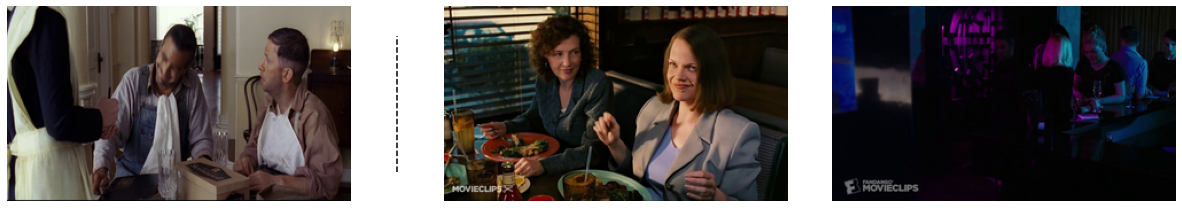

In [21]:
idx=161
positive_dixs= img_pairs.event_based_similarity([idx]).topk(2, dim=1, largest=True)[1][0]
visual_multiple_fig(record_img_event, records_events, idx, positive_dixs, verbose=True)

In [22]:
records_events['movieclips_American_Psycho/MCo6TtUkCWc@16.jpg']

KeyError: 'movieclips_American_Psycho/MCo6TtUkCWc@16.jpg'

## Generate Caption Cosine based similarity && Visualize image-text relations

In [ ]:
cosine_img_pairs = ImgPostivePairs(split=split, cache=record_cache, load_cache=True, simi_trick='cosine')

In [ ]:
recorded_idxs = [700, 760, 850]

In [ ]:
idx=161
positive_dixs= cosine_img_pairs.event_based_similarity([idx]).topk(2, dim=1, largest=True)[1][0]
visual_multiple_fig(record_img_event, records_events, idx, positive_dixs, verbose=True)

In [ ]:
cosine_img_pairs.event_based_similarity([idx]).max()

In [ ]:
records_events['lsmdc_0026_The_Big_Fish/0026_The_Big_Fish_01.49.51.381-01.49.52.444@0.jpg']

## Visualize the image and its positive pair according to the EBS and Cosine

3780
similar samples for lsmdc_1010_TITANIC/1010_TITANIC_02.34.42.828-02.34.43.864@0.jpg..
idx: 3780, event: [person] is holding onto a bronze statue while waves of water crash around him; [intent] hold on for his life; [intent] wait for help to arrive; [place] inside a sinking ship
, [{'before': ['sense his own death', 'grow more worried', 'find something to hold on to', 'swim towards the statue'], 'after': ['scream for help', 'try to climb back up the stairs', 'want to keep his head above water', 'continue holding onto the statue']}]

idx: 9321, event: [person] attempts to climb back into the boat after falling into the water; [intent] keep from drowning; [intent] dry off; [intent] stay safe; [place] on the lake
, [{'before': ['be riding in a boat', 'get thrown out of boat', 'lose his balance', 'swim over to the boat'], 'after': ["pull himself back in with 2's help", 'catch a breath', "reach out for 2's help", 'tip over the boat']}]

idx: 2845, event: [person] is losing the fight and

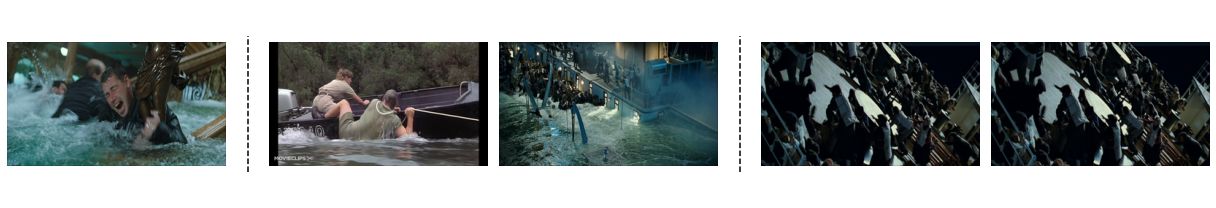

In [27]:
idx=0
for idx, ref in enumerate(record_img_event):
    if ref[0]=='lsmdc_1010_TITANIC/1010_TITANIC_02.34.42.828-02.34.43.864@0.jpg':
        print(idx)
        break
idxs = [idx]
print("similar samples for lsmdc_1010_TITANIC/1010_TITANIC_02.34.42.828-02.34.43.864@0.jpg..")
for idx in idxs:
    positive_dixs= img_pairs.event_based_similarity([idx]).topk(2, dim=1, largest=True)[1][0]
    cosine_positive_dixs= cosine_img_pairs.event_based_similarity([idx]).topk(2, dim=1, largest=True)[1][0]
    visual_multiple_fig(record_img_event, records_events, idx, positive_dixs, cosine_positive_dixs, verbose=True)

idx: 1002, event: [person] is walking through the station; [intent] investigate the station; [intent] look for clues; [place] at the train station
, [{'before': ['travel to the station', 'find the right platform at the station', 'be at the station', 'be looking for someone'], 'after': ['look through the broken glass', 'run away', 'quickly find car and leave', 'go hideout']}]

idx: 27997, event: [person] is walking behind [person] looking suspicious; [intent] avoid getting on the train; [intent] find his mother before getting on the train; [place] at a train station
, [{'before': ['put on his coat', 'hide behind the pillar', 'not want to be seen by 5', 'walk up behind 5'], 'after': ['sneak around 5', 'run away', "take something out of 5's pocket", 'sneak away from 5']}]

idx: 15474, event: [person] is walking through the station; [intent] find the platform for a train; [intent] leave the station to get to her destination; [place] in a subway station
, [{'before': ['travel to the station

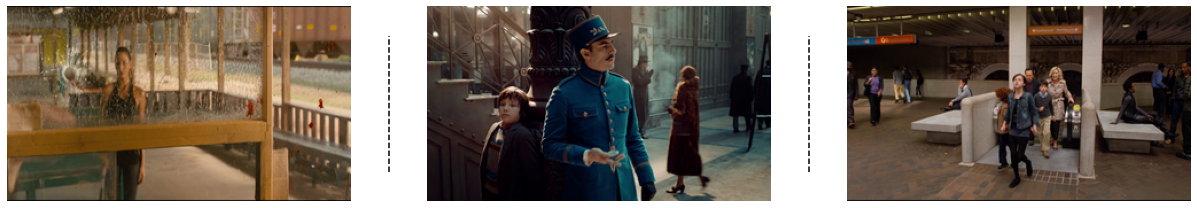

In [38]:
idxs = [1002]

for idx in idxs:
    positive_dixs= img_pairs.event_based_similarity([idx]).topk(1, dim=1, largest=True)[1][0]
    cosine_positive_dixs= cosine_img_pairs.event_based_similarity([idx]).topk(1, dim=1, largest=True)[1][0]
    visual_multiple_fig(record_img_event, records_events, idx, positive_dixs, cosine_positive_dixs, verbose=True)

In [31]:
perfect_record_idxs_train = [739, 161, 874, 701, 1789, 759]

In [29]:
idxs = 1000

idx: 1007, event: [person] is looking at [person] in a concerned way like she is waiting for something; [intent] show [person] she didn't approve of him; [intent] get [person] to explain himself more; [place] at a festival
, [{'before': ['ask 2 a question', "listen to 2's answer", 'sit on the bed', 'begin speaking to 2'], 'after': ["respond to 2's answer", 'ask another question', 'react to the news', 'yell at 2']}]

idx: 77551, event: [person] is looking at someone with a bit of disbelief; [intent] show she didn't believe the other person; [intent] epress her skepticism; [place] in an office
, [{'before': ['take the box from someone in front of her', 'ask her employee to report', 'be engaged in conversation with 1', 'notice someone else walk in'], 'after': ['put the box in her desk', 'tell him he has done well', 'invite the new person over', 'engage in conversation with the person']}]

idx: 80575, event: [person] is looking at [person] with concern; [intent] get [person] to change her 

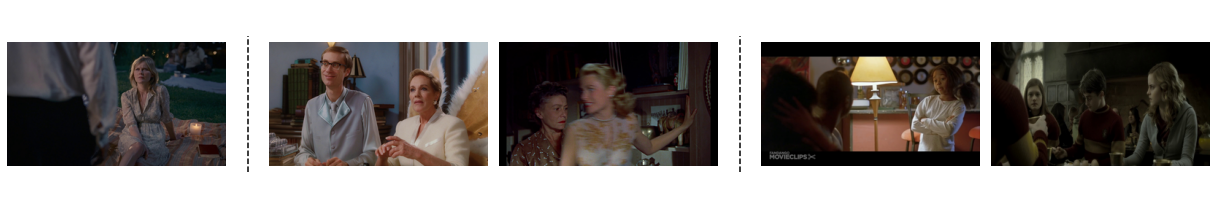

In [32]:
while True:
    idxs += 1
    cosine_positive_dixs= cosine_img_pairs.event_based_similarity([idxs]).topk(2, dim=1, largest=True)[1][0]
    positive_dixs= img_pairs.event_based_similarity([idxs]).topk(2, dim=1, largest=True)[1][0]
    
    ref = record_img_event[cosine_positive_dixs[0]]
    if len(ref[2])>=8:
        if positive_dixs[0] != cosine_positive_dixs[0] and  positive_dixs[0] != cosine_positive_dixs[1] and positive_dixs[1] != cosine_positive_dixs[0] and  positive_dixs[1] != cosine_positive_dixs[1]:
            visual_multiple_fig(record_img_event, records_events, idxs, positive_dixs, cosine_positive_dixs, verbose=True)
            break
    

In [93]:
max_simis  =  []
for i in range(5000):
    cosine_positive_dixs= cosine_img_pairs.event_based_similarity([i]).topk(1, dim=1, largest=True)[1][0]
    positive_dixs= img_pairs.event_based_similarity([i]).topk(1, dim=1, largest=True)[1][0]
    if positive_dixs[0] != cosine_positive_dixs[0]:
        max_simis.append(img_pairs.event_based_similarity([i]).max().item())
    else:
        max_simis.append(0)
max_simis = torch.tensor(max_simis)

In [96]:
max_simis.topk(15, dim=0, largest=True)

torch.return_types.topk(
values=tensor([9.3477, 9.2994, 9.2888, 9.2399, 9.1957, 9.1679, 9.1581, 9.1429, 9.1370,
        9.1255, 9.1109, 9.0932, 9.0728, 9.0591, 9.0575]),
indices=tensor([1688, 1690,  739, 3304, 1646,  701, 2868,  899, 1748, 3873, 3487,  874,
        4660, 3917, 4846]))

In [46]:
cosine_img_pairs.event_based_similarity([idxs]).max()

tensor(0.7085, device='cuda:0')

## Visualize PDF delta

In [2]:
from matplotlib.pyplot import hist
import seaborn as sns
import torch, os

coeffi_CKPT = torch.load(os.path.join(record_cache, 'accumulated_scores_best.pth'))
coeffi_left = coeffi_CKPT["{}_accumulated_scores_left".format(split)]
coeffi_right = coeffi_CKPT["{}_accumulated_scores_right".format(split)]


In [3]:
def dis_abnorm(coeffi):
    coeffi[coeffi<0] = 0
    coeffi[coeffi>10] = 0
    return coeffi

In [4]:

coeffi_left = dis_abnorm(coeffi_left)

coeffi_right = dis_abnorm(coeffi_right)


In [5]:
coeffi_right.mean()

tensor(2.8991)

/home/mag0a/anaconda3/envs/vl-bert/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mag0a/anaconda3/envs/vl-bert/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font f

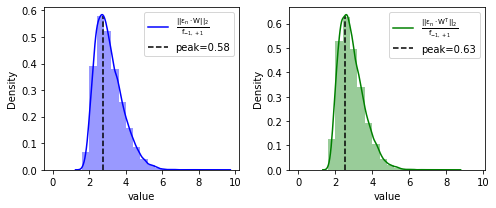

In [6]:
bins = list(np.arange(0, 10, 0.4))
figure = plt.figure(figsize=(7,3))
axs = figure.subplots(nrows=1, ncols=2)
sns.distplot(coeffi_left, bins, hist=True, kde=True, color='blue', ax=axs[0])
axs[0].vlines(2.75, 0, 0.58, colors = "k", linestyles = "dashed")
axs[0].legend([r'$\frac{||\epsilon_{n}\cdot W||_2}{f_{-1,+1}}$', 'peak=0.58'])

sns.distplot(coeffi_right, bins, hist=True, kde=True, color='green', ax=axs[1])
axs[1].vlines(2.55, 0, 0.63, colors = "k", linestyles = "dashed")
axs[1].legend([r'$\frac{||\epsilon_{n}\cdot W^T||_2}{f_{-1,+1}}$', 'peak=0.63'])


axs[0].set_xticks(list(range(0, 12, 2)))
axs[1].set_xticks(list(range(0, 12, 2)))
axs[0].set_xlabel(r"value")
axs[1].set_xlabel(r"value")
plt.tight_layout()
plt.savefig("{}.png".format("pdf_delta"))

## Image Sequence Ordering Visualization

In [103]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

def convert_str_mins(time):
    time_list = time.split('.')
    assert len(time_list) == 4
    time = int(time_list[-1]) + int(time_list[-2]) * 60 + int(time_list[-3]) * 3600
    return time


def parse_file_name(file_name):
    ori_file_name = file_name
    file_name = file_name.split('@')
    at_index = file_name[-1].split('.')[0]
    file_name = file_name[0].split('-')
    time_end = file_name[-1]
    file_name = file_name[-2]
    time_begin = file_name[-len("00.17.26.000"):]
    try:
        return convert_str_mins(time_begin), convert_str_mins(time_end), at_index
    except:
        print(ori_file_name)


def is_in_one_cluster(file_prev, file):
    prev_time_begin, prev_time_end, prev_at_index = parse_file_name(file_prev)
    time_begin, time_end, at_index = parse_file_name(file)
    if time_begin == prev_time_begin:
        return True
    else:
        return False


def sample_one_cluster(one_cluster):
    samples = []
    one_cluster = sorted(one_cluster, key=lambda x: int(x.split('@')[1].split('.')[0]))
    if len(one_cluster) > 1:
        for i, img in enumerate(one_cluster):
            for neg_img in one_cluster[:i]:
                samples.append([img, neg_img, 0])
            for pos_img in one_cluster[i + 1:]:
                samples.append([img, pos_img, 1])
    return samples


def gen_image_clusters(path):
    image_clusters = []
    g = os.walk(path)
    for path, dir_list, file_list in g:
        for dir_name in dir_list:
            files = [os.path.join(dir_name, f) for f in os.listdir(os.path.join(path, dir_name)) if
                     ('jpg' in f) and ('npy' not in f)]
            files = sorted(files)
            file_prev = files[0]
            one_cluster = [file_prev]
            if 'lsmdc' in dir_name:  # only lsmdc dir has time stamp
                for file in files[1:]:
                    if is_in_one_cluster(file_prev, file):
                        one_cluster.append(file)
                    else:
                        image_clusters.append(one_cluster)
                        one_cluster = [file]
                    file_prev = file
            else:
                for file in files[1:]:
                    if file_prev.split('@')[0] == file.split('@')[0]:
                        one_cluster.append(file)
                    else:
                        image_clusters.append(one_cluster)
                        one_cluster = [file]
                    file_prev = file

    image_clusters = [one_cluster for one_cluster in image_clusters if len(one_cluster) >= 2]
    return image_clusters


def gen_image_ordering_cache(image_clusters):
    image_ordering_cache = []
    for one_cluster in image_clusters:
        samples = sample_one_cluster(one_cluster)
        image_ordering_cache.extend(samples)
    return image_ordering_cache




def transform(img):
    img = img.resize((300, 170), Image.ANTIALIAS)
    return img


def clear_ax(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    
def visualize_one_cluster(image_cluster):
    figure = plt.figure(figsize=(17,5))

    axs = figure.subplots(nrows=1, ncols=len(image_cluster))

    for i, img_fn in enumerate(image_cluster):
        jpg_path = os.path.join(path, img_fn)
        img = Image.open(jpg_path)
        img = transform(img)
        axs[i].imshow(img)
        clear_ax(axs[i])
        
    plt.tight_layout()
    plt.savefig("samples/{}.png".format(image_cluster[0].split('/')[1].split('@')[0]))


In [69]:

path = "/ibex/scratch/mag0a/Github/visual-comet/data/vcr1images"

# path = "/ibex/scratch/mag0a/Github/VL-BERT/data/vcr/vcr1images"

image_clusters = gen_image_clusters(path)

In [106]:
img_fn_record_mapping = {}
for record in records:
    img_fn = record['img_fn'].split('@')[0]
    if img_fn in img_fn_record_mapping:
        img_fn_record_mapping[img_fn].append({'img_fn': record['img_fn'], 'event': record['event']})
    else:
        img_fn_record_mapping[img_fn] = [{'img_fn': record['img_fn'], 'event': record['event']}]

In [97]:
seven_image_clusters = []
for image_cluster in image_clusters:
    if len(image_cluster) == 7:
        seven_image_clusters.append(image_cluster)

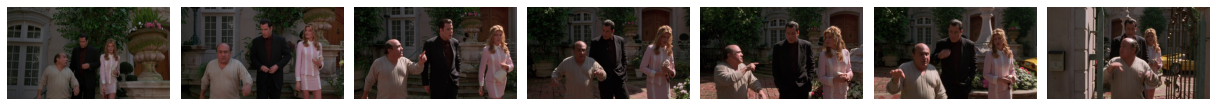

In [104]:
img_cluster = seven_image_clusters[5]
visualize_one_cluster(sorted(img_cluster, key=lambda x: int(x.split('@')[1].split('.')[0])))


In [99]:
sorted(img_cluster, key=lambda x: int(x.split('@')[1].split('.')[0]))

['lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@0.jpg',
 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@1.jpg',
 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@2.jpg',
 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@3.jpg',
 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@4.jpg',
 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@5.jpg',
 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@6.jpg']

In [107]:
img_fn_record_mapping[img_cluster[0].split('@')[0]]

[{'img_fn': 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@3.jpg',
  'event': '1 is running away from the others'},
 {'img_fn': 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@3.jpg',
  'event': '2 is talking to 1'},
 {'img_fn': 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@3.jpg',
  'event': '3 is upset and clutching onto her belongings'},
 {'img_fn': 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@5.jpg',
  'event': '1 is walking with 2 and 3 after exiting the building'},
 {'img_fn': 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@5.jpg',
  'event': '3 is leaning forward trying to hear 1'},
 {'img_fn': 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@5.jpg',
  'event': '2 is walking beside 1 and 3 with a look of disgust on her face'},
 {'img_fn': 'lsmdc_0012_Get_Shorty/0012_Get_Shorty_00.57.42.065-00.57.56.065@2.jpg',
  'event': '2 is talking to 3 and 1'},
 {'img_fn': 'lsmdc_0012_G

## Generate Image samples for figure 1

In [11]:
assert split='val'

anchor_img = 'lsmdc_1010_TITANIC/1010_TITANIC_02.34.42.828-02.34.43.864@0.jpg'

In [12]:
records_events[anchor_img]

{'[person] is holding onto a bronze statue while waves of water crash around him; [intent] hold on for his life; [intent] wait for help to arrive; [place] inside a sinking ship': [{'before': ['sense his own death',
    'grow more worried',
    'find something to hold on to',
    'swim towards the statue'],
   'after': ['scream for help',
    'try to climb back up the stairs',
    'want to keep his head above water',
    'continue holding onto the statue']}],
 '[person] is swimming to the stairs to get out of the violent currents of water; [intent] get to the top deck; [intent] swim to safety; [place] inside a sinking ship': [{'before': ['be in a accident while inside a ship',
    'notice water rushing in with no escape',
    'get caught in a rush of water',
    'start moving their arms against the water'],
   'after': ['try to help 3 and 4 out of the ship',
    'escape from the ship to safety',
    'look for something to hold onto',
    'try to get to higher ground']}]}

In [24]:
## find index of anchor_img
for anchor_img_index, data in enumerate(record_img_event):
    if anchor_img == data[0]:
        print(anchor_img_index)
        break


3780


3780
similar samples for lsmdc_1010_TITANIC/1010_TITANIC_02.34.42.828-02.34.43.864@0.jpg..
idx: 3780, event: [person] is holding onto a bronze statue while waves of water crash around him; [intent] hold on for his life; [intent] wait for help to arrive; [place] inside a sinking ship
, [{'before': ['sense his own death', 'grow more worried', 'find something to hold on to', 'swim towards the statue'], 'after': ['scream for help', 'try to climb back up the stairs', 'want to keep his head above water', 'continue holding onto the statue']}]

idx: 9321, event: [person] attempts to climb back into the boat after falling into the water; [intent] keep from drowning; [intent] dry off; [intent] stay safe; [place] on the lake
, [{'before': ['be riding in a boat', 'get thrown out of boat', 'lose his balance', 'swim over to the boat'], 'after': ["pull himself back in with 2's help", 'catch a breath', "reach out for 2's help", 'tip over the boat']}]

idx: 2845, event: [person] is losing the fight and

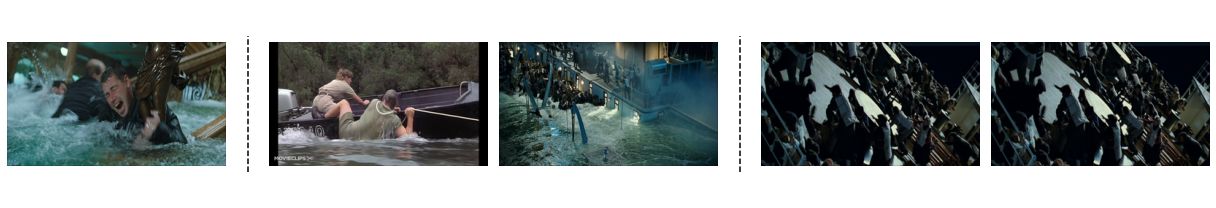

In [28]:
## find index of anchor_img
for anchor_img_index, data in enumerate(record_img_event):
    if anchor_img == data[0]:
        print(anchor_img_index)
        break
idxs = [anchor_img_index]
print("similar samples for lsmdc_1010_TITANIC/1010_TITANIC_02.34.42.828-02.34.43.864@0.jpg..")
for idx in idxs:
    positive_dixs= img_pairs.event_based_similarity([idx]).topk(2, dim=1, largest=True)[1][0]
    cosine_positive_dixs= cosine_img_pairs.event_based_similarity([idx]).topk(2, dim=1, largest=True)[1][0]
    visual_multiple_fig(record_img_event, records_events, idx, positive_dixs, cosine_positive_dixs, verbose=True)

In [29]:
record_img_event[9321]

['movieclips_The_Crocodile_Hunter_Collision_Course/P06IeXkgRNA@41.jpg',
 'movieclips_The_Crocodile_Hunter_Collision_Course/P06IeXkgRNA@41.json',
 '[person] attempts to climb back into the boat after falling into the water; [intent] keep from drowning; [intent] dry off; [intent] stay safe; [place] on the lake\n']

In [31]:
records_events[record_img_event[positive_dixs[0]][0]]

{'[person] attempts to climb back into the boat after falling into the water; [intent] keep from drowning; [intent] dry off; [intent] stay safe; [place] on the lake': [{'before': ['be riding in a boat',
    'get thrown out of boat',
    'lose his balance',
    'swim over to the boat'],
   'after': ["pull himself back in with 2's help",
    'catch a breath',
    "reach out for 2's help",
    'tip over the boat']}],
 '[person] steadies the boat on one side as [person] climbs in on the other side; [intent] prevent the boat from tipping over; [intent] avoid going into the water herself; [place] on the lake': [{'before': ['notice 1 fall out of the boat',
    'throw 1 a line',
    'be concerned about the boat tipping',
    'see 1 fall overboard',
    'want to help 1 back onboard'],
   'after': ['steady the boat until 1 gets on',
    'laugh with 1 about the event',
    'help 1 dry off',
    'drive the boat to shore',
    'extend her hand out to 1',
    'pull 1 into the boat']}]}

In [32]:
records_events[anchor_img]

{'[person] is holding onto a bronze statue while waves of water crash around him; [intent] hold on for his life; [intent] wait for help to arrive; [place] inside a sinking ship': [{'before': ['sense his own death',
    'grow more worried',
    'find something to hold on to',
    'swim towards the statue'],
   'after': ['scream for help',
    'try to climb back up the stairs',
    'want to keep his head above water',
    'continue holding onto the statue']}],
 '[person] is swimming to the stairs to get out of the violent currents of water; [intent] get to the top deck; [intent] swim to safety; [place] inside a sinking ship': [{'before': ['be in a accident while inside a ship',
    'notice water rushing in with no escape',
    'get caught in a rush of water',
    'start moving their arms against the water'],
   'after': ['try to help 3 and 4 out of the ship',
    'escape from the ship to safety',
    'look for something to hold onto',
    'try to get to higher ground']}]}

In [34]:
import tensorflow_hub as hub
import torch.nn.functional as F

embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5")


In [49]:
def before_after_smilarity(vect1, vect2):
    similarity = F.cosine_similarity(vect1, vect2, dim=1)
    return similarity

In [50]:
## find similar before and after events but different now event

anchor_before, anchor_after = '; '.join(records[anchor_img_index]['before']), '; '.join(records[anchor_img_index]['after'])
anchor_before_vect, anchor_after_vect = torch.tensor(embed([anchor_before]).numpy()), torch.tensor(embed([anchor_after]).numpy())

before_similarities, after_similarities = [], []

for record in records:
    before, after = '; '.join(record['before']), '; '.join(record['after'])
    before_vect, after_vect = torch.tensor(embed([before]).numpy()), torch.tensor(embed([after]).numpy())
    before_sim, after_sim = before_after_smilarity(anchor_before_vect, before_vect), before_after_smilarity(anchor_after_vect, after_vect)
    before_similarities.append(before_sim)
    after_similarities.append(after_sim)

In [54]:
before_similarities = torch.tensor(before_similarities)
after_similarities = torch.tensor(after_similarities)

In [55]:
tmp = before_similarities+after_similarities

In [65]:
tmp.topk(15, dim=0, largest=True)

torch.return_types.topk(
values=tensor([2.0000, 0.9379, 0.9365, 0.9194, 0.8968, 0.8856, 0.8776, 0.8764, 0.8758,
        0.8734, 0.8698, 0.8682, 0.8652, 0.8621, 0.8483]),
indices=tensor([ 3780,   181,  7646,  7733,  5114,  5479,  4666,  7411,  4214, 13759,
        12465,  5977,  5083,  6380,  7145]))

In [72]:
positive_idxs = [5479,  4666,  7411,  4214, 13759]

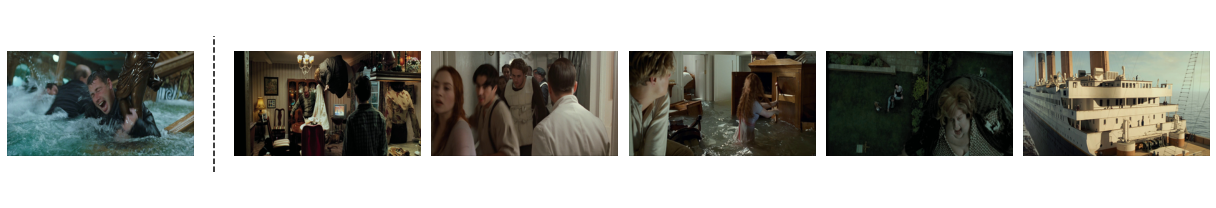

In [73]:
visual_multiple_fig(record_img_event, records_events, anchor_img_index, positive_idxs, cosine_positive_dixs=[], verbose=False)

In [74]:
records[5479]

{'img_fn': 'lsmdc_1054_Harry_Potter_and_the_prisoner_of_azkaban/1054_Harry_Potter_and_the_prisoner_of_azkaban_00.05.17.865-00.05.20.151@0.jpg',
 'movie': '1054_Harry_Potter_and_the_prisoner_of_azkaban',
 'metadata_fn': 'lsmdc_1054_Harry_Potter_and_the_prisoner_of_azkaban/1054_Harry_Potter_and_the_prisoner_of_azkaban_00.05.17.865-00.05.20.151@0.json',
 'split': 'val',
 'place': 'in a dining room',
 'event': '1 has her hands against the counter as she backs away',
 'intent': ['get away from 4', 'convey her fear'],
 'before': ["be in shock at what's happening",
  'see something he wanted to get away from',
  'see someone floating',
  'see someone getting bigger'],
 'after': ['try to pull the woman down',
  'scream in surprise and raise their hands',
  'scream for help',
  'yell at 2 to stop']}